# Data Generators

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 10/02/2025 | Martin | Created   | Created new notebook for Data Generation notes | 

# Content

* [Setting up a data generator](#setting-up-a-data-generator)

# Setting up a Data Generator

Provide a method to create batches of the data at different sizes

* Process code for the generator capable of generating random batches on the fly.
* `Sequence` class used as the base object for fitting a sequence of data

In [2]:
from tensorflow.keras.utils import Sequence

In [ ]:
class DataGenerator(Sequence):
  def __init__ (self, X, y, tabular_transformer=None, batch_size=32, shffle=False, dict_output=False):

    self.X = X
    self.y = y
    self.tbt = tabular_transformer
    self.tabular_transformer = tabular_transformer
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.dict_output = dict_output
    self.indexes = self._build_index()
    self.on_epoch_end()
    self.item = 0
  
  def _build_index(self):
    # Builds the index for all procided data
    return np.arange(len(self.y)) 
  
  def on_epoch_end(self):
    # Shuffle at the end of every epoch
    if self.shuffle:
      np.radom.shuffle(self.indexes)
  
  def __len__(self):
    # Returns the number of batches per epoch
    return int(len(self.indexes) / self.batch_size) + 1
  
  def __iter__(self):
    # Returns an iterable
    for i in range(self.__len__()):
      self.item = i
      yield self.__getitem(index=i)
    
    self.item = 0
  
  def __next__(self):
    return self.__getitem__(index=self.item)
  
  def __call__(self):
    return self.__iter__()
  
  def __data_generation(self, selection):
    if self.tbt is not None:
      if self.dict_output:
        dct = {
          'input_'+str(j): arr for j, arr in enumerate(self.tbt.transform(self.X.iloc[selection, :]))
        }
        return dct, self.y[selection]
      else:
        return self.tbt.transform(self.X.iloc[selection, :]), self.y[selection]
    else:
      return self.X.iloc[selection, :], self.y[selection]
  
  def __getitem__(self, index):
    indexes = self.indexes[index* self.batch_size: (index+1)*self.batch_size]
    samples, labels = self.__data_generation(indexes)
    return samples, labels, [None]


Components:
* `_build_index` - Creates an index of the provided data
* `on_epoch_end` - At the end of each epoch, the method will randomly shuffle data
* `__len__` - Reports how many batches are required to complete an epoch
* `__iter__` - Renders the class as an iterable
* `__next__` - Calls the enxt batch
* `__call__` - Returns the `__iter__` method call
* `__data_generation` - Returns the transformed output
* `__getitem__` - Splits the data into vatches and calls the `__data_generation` method for the transformation

---

# Custom Activations

Tabular data is sparse making it hard to perform backpropogation.

* 💡 __IDEA:__ Use alternative activation functions: SeLU, GeLU, and Mish to during backpropogation to prevent gradient from vanishing
* [_Gaussian Error Linear Units (GeLU)_](https://arxiv.org/abs/1606.08415)
* [_Mish_](https://arxiv.org/abs/1908.08681) - Self regularised non-monotonic neural activation function

In [9]:
from tensorflow import keras as keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

`get_custom_objects` is a function that allows you to recrod new functions in a custom Tensorflow objects to easily recall them as strings in layer parameters

In [5]:
def gelu(x):
  return 0.5 * x *  (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

keras.utils.get_custom_objects().update({'gelu': keras.layers.Activation(gelu)})

In [7]:
def mish(inputs):
  return inputs * tf.math.tanh(tf.math.softplus(inputs))

keras.utils.get_custom_objects().update({'mish': keras.layers.Activation(mish)})

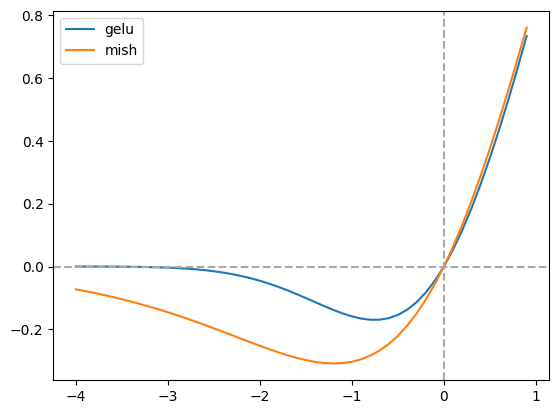

In [10]:
gelu_vals = list()
mish_vals = list()
abscissa = np.arange(-4, 1, 0.1)
for val in abscissa:
    gelu_vals.append(gelu(tf.cast(val, tf.float32)).numpy())
    mish_vals.append(mish(tf.cast(val, tf.float32)).numpy())
    
plt.plot(abscissa, gelu_vals, label='gelu')
plt.plot(abscissa, mish_vals, label='mish')
plt.axvline(x=0.0, linestyle='--', color='darkgray')
plt.axhline(y=0.0, linestyle='--', color='darkgray')
plt.legend()
plt.show()

__Details about the functions__

1. Inputs greater than zero are identically mapped as outputs
2. Inputs less than zero are dampened transformations of the negative value. They remain negative but taper towards zero as the value gets more negative. This prevents too negative values from impacting the algorithm too much

Allows gradient descent to store and use negative values compared to ReLU which turns negative values off

---

In [ ]:
pg 329